## Supervised Land Cover Classification using Google Earth Engine and JavaScript (Expriment Replication)

https://medium.com/@northamericangeoscientistsorg/supervised-land-cover-classification-using-google-earth-engine-and-javascript-9f7740d84863

In [74]:
import ee
ee.Authenticate()
%pip install folium

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [75]:
# Import the Earth Engine library and Folium for mapping
import ee
import folium

# Initialize Earth Engine
ee.Initialize()

# Load a Landsat 8 image by its asset ID
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')

# Define a visualization parameter for the image (e.g., bands and color)
visParams = {
  'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue bands
  'max': 0.3  # Adjust this value for image brightness
}

# Create a map centered on the image
map = folium.Map(location=[image.geometry().centroid().coordinates().get(1).getInfo(), 
                           image.geometry().centroid().coordinates().get(0).getInfo()], zoom_start=10)

# Add the Landsat image as a tile layer from Earth Engine
tile_url = image.getMapId(visParams)
folium.TileLayer(
    tiles=tile_url['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='Landsat Image'
).add_to(map)

# Display the map
map





Sampling Image and Creating Training and Testing Sets

In [79]:

image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')

# Define a region of interest (replace with your region)
region = ee.Geometry.Rectangle(-122.085, 37.422, -121.774, 37.703)

# Sample the image at the points and add a random column
points = image.sample(
    region=region,
    scale=30,
    numPixels=5000,
    seed=0,
    geometries=True  # Set this to False to ignore geometries
).randomColumn('random')

# Make a training-testing split
training = points.filter(ee.Filter.lt('random', 0.7))
testing = points.filter(ee.Filter.gte('random', 0.7))

# Print the number of points in each split for verification
print('Number of points in training:', training.size().getInfo())
print('Number of points in testing:', testing.size().getInfo())


Number of points in training: 3473
Number of points in testing: 1527


K-means clusterer and train it on our training set. Creates a clusterer object using the Weka K-Means algorithm with 15 clusters. This code trains a classifier using the CART (Classification and Regression Trees) algorithm from the smile library. The code performs clustering using the K-Means algorithm and then uses the resulting clusters as labels to train a classifier. The trained classifier is then used to classify the input image, producing an output image with class labels for each pixel.

In [48]:
# Instantiate the clusterer and train it
clusterer = ee.Clusterer.wekaKMeans(15).train(training)

# Train a classifier using the clusters as labels
trained = ee.Classifier.smileCart().train(
    features=training,
    classProperty='cluster',
    inputProperties=image.bandNames()
)
output = image.classify(trained)



Load image, convert to grayscale, standardize the data, apply spectral clustering, 

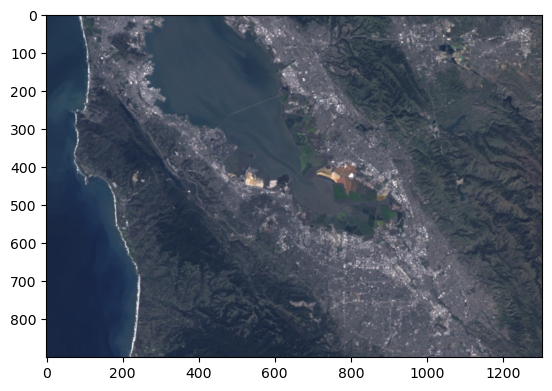

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler

# Load the image
image_path = '/Users/johnwishart/Desktop/IST718/pic.png'
original_image = io.imread(image_path)

# Convert the color image to grayscale
image_2d = np.mean(original_image, axis=2)

# Standardize the data for spectral clustering
scaler = StandardScaler()
image_2d_scaled = scaler.fit_transform(image_2d)

# Define spectral clustering parameters (you can adjust these)
n_clusters = 15  # Number of clusters

# Apply spectral clustering
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(image_2d_scaled)

# display the image
plt.imshow(original_image)
plt.show() 

/var/folders/hs/qnv8rj497vj3bn3xsct8ktp40000gn/T/ipykernel_30317/2039751341.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('hsv', n_clusters)


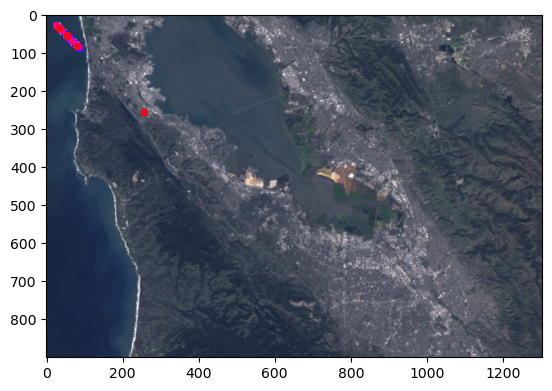

In [78]:
# Overlay cluster labels on the original image

# Convert the color image to grayscale
image_2d = np.mean(original_image, axis=2)

# Standardize the data for spectral clustering
scaler = StandardScaler()
image_2d_scaled = scaler.fit_transform(image_2d)

# Define spectral clustering parameters (you can adjust these)
n_clusters = 15  # Number of clusters

# Apply spectral clustering
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(image_2d_scaled)

# Display the image with cluster labels overlaid
fig, ax = plt.subplots()
ax.imshow(original_image)

# Create a color map for the clusters
color_map = plt.cm.get_cmap('hsv', n_clusters)

# Overlay the cluster labels on top of the image
for cluster in range(n_clusters):
    cluster_pixels = original_image[labels == cluster]
    ax.scatter(cluster_pixels[:, 1], cluster_pixels[:, 0], color=color_map(cluster), s=15)

plt.show()
